# Intro

This notebook plots the results generated by ```time_resolved_decoding.py``` code, which is the time resolved decoding results for all the sessions.

---
# Setup

In [1]:
##% imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import seaborn as sns
import xarray as xr

from popy.decoding.decoder_plotting import show_population_decoder_results, show_single_session_decoder, show_prop_signif_units
from popy.decoding.decoder_tools import mask_N_consecutives
from popy.plotting.plot_cortical_grid import get_grid_location, init_location_grid, plot_matrix
from popy.plotting.plotting_tools import plot_keypoints

import popy.config as cfg
PATH = cfg.PROJECT_PATH_LOCAL
import os

# set fontsize to 8
plt.rcParams.update({'font.size': 8})

In [2]:
##% data tools
def remove_outliers_zscore(df, columns, threshold=5):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    return df[(z_scores < threshold).all(axis=1)]

def load_decoding_res(monkey, folder='basics'):
    xr_res = xr.open_dataset(os.path.join(PATH, 'notebooks', 'decoders', 'population_decoding', 'results', folder, f'{monkey}_decoding_results.nc'))
    xr_res.load()

    # remove nans along 'session' dimension
    #xr_res = xr_res.dropna('session')
    
    return xr_res

def load_decoding_res_new(folder='basics'):
    xr_res = xr.open_dataset(os.path.join(PATH, 'notebooks', 'decoders', 'population_decoding', 'results', folder, 'scores.nc'))
    xr_res.load()

    # remove nans along 'session' dimension
    #xr_res = xr_res.dropna('session')
    
    return xr_res

def mask_N_consecutives(mask_xr, N=4):
    """
    Takes a mask (True/False) and sets to False any True value that is not part of N consecutive True values.
    
    Parameters
    ----------
    data : Xarray
        3D Xarray with dimensions (session, time, area)
    N : int
        Number of consecutive non-significant bins to mask
        
    Returns
    -------
    data_masked : Xarray
        3D Xarray with dimensions (session, time, area) with N consecutive non-significant bins masked.
    """

    # find where N consecutive values are False
    mask = np.empty(mask_xr.shape)
    for sess_id in range(mask_xr.shape[0]):
        for area_id in range(mask_xr.shape[2]):
            # get session data
            session_temp = mask_xr[sess_id, :, area_id].values

            consecutive_count = 0
            candidate_ids = []
            unit_signif_ids = []
            for i, if_signif_bin in enumerate(session_temp):
                # if not False, add to count
                if if_signif_bin:
                    consecutive_count += 1
                    candidate_ids.append(i)  # add to candidate indices (may or may not be part of N consecutive bins)
                    if consecutive_count >= N:
                        unit_signif_ids += candidate_ids  # add to list of significant indices
                        candidate_ids = []  # reset candidate ids
                else:  # reset
                    consecutive_count = 0
                    candidate_ids = []
            # create mask for this session (1 if significant, 0 if not) 
            unit_signif = np.zeros_like(session_temp)
            unit_signif[unit_signif_ids] = 1

            mask[sess_id, :, area_id] = unit_signif

    #data_masked = data.where(mask == 1)
    mask = mask.astype(bool)
    mask_xr.data = mask
    return mask_xr


In [3]:
##% plotting
def plot_identity(res_q_target, res_val_target, labels=None, title=None):
    # plot heatmap
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2], width_ratios=[2, 2])

    areas = ['LPFC', 'MCC']

    for i in range(2):
        matrix_q_temp = res_q_target.sel(area=areas[i])  # select area
        df_q_temp = matrix_q_temp.to_dataframe().reset_index()  # convert to dataframe
        matrix_val_temp = res_val_target.sel(area=areas[i])  # select area
        df_val_temp = matrix_val_temp.to_dataframe().reset_index()  # convert to dataframe

        # align dataframes (i.e. drop sessions that are not in both, and sort by session and time)
        df_temp = pd.merge(df_q_temp, df_val_temp, on=['session', 'time'], suffixes=('_q', '_val'))
        df_temp = df_temp.dropna(subset=['scores_q', 'scores_val'])
        # remove outliers (i.e. values that are too far from the mean)
        #df_temp = remove_outliers_zscore(df_temp, ['scores_q', 'scores_val'])
        df_temp = df_temp.loc[(df_temp['scores_q'] > 0) & (df_temp['scores_val'] > 0)]  # remove negative values

        # scatter plot 'score_q' vs 'score_val'
        X = df_temp[['scores_q', 'scores_val']].values

        # define identity line and fit line
        a, b = 1.0, 0.0  # slope, intercept
        a_, b_ = np.polyfit(X[:, 0], X[:, 1], 1)

        # projection on normal vector of identity line
        linepoint = np.array([0.0, b])
        normal_vector = np.array([a, -1.0])
        normal_vector /= np.linalg.norm(normal_vector)
        projection = np.dot(X - linepoint, normal_vector)  # projection on normal vector

        # scatter plot 'score_q' vs 'score_val'
        ax1 = plt.subplot(gs[i, 0])
        ax1.scatter(df_temp['scores_q'], df_temp['scores_val'], alpha=.2, color='black', s=1)
        # Plot the lines
        x_line = np.linspace(np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()]), 10)
        y_line_identity = a * x_line + b
        y_line_fit = a_ * x_line + b_
        ax1.plot(x_line, y_line_identity, 'r-', label='Identity line')
        ax1.plot(x_line, y_line_fit, 'g-', label='Line of best fit')
    
        ax1.axhline(0, color='black', linewidth=.5)
        ax1.axvline(0, color='black', linewidth=.5)

        # x and y span are the same
        ax1.set_xlim([np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()])])
        ax1.set_ylim([np.min([X[:, 0].min(), X[:, 1].min()]), np.max([X[:, 0].max(), X[:, 1].max()])])
        
        ax1.set_xlabel(f'{labels[0]} value coding (R2)')
        ax1.set_ylabel(f'{labels[1]} value coding (R2)')

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.grid(alpha=.5)
        ax1.set_title(areas[i])
        ax1.legend()

        # histogram of projection
        ax2 = plt.subplot(gs[i, 1])
        bins = np.linspace(-np.max(np.abs(projection)), np.max(np.abs(projection)), 11)
        ax2.hist(projection, bins=bins, alpha=.5, linewidth=1, edgecolor='black')
        ax2.axvline(0, color='red', linewidth=1, label='Identity line')
        ax2.set_xlabel(f'Distance from identity line\n<-- {labels[1]} better | {labels[0]} better -->')
        ax2.set_ylabel('Count')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.grid(alpha=.5)
        ax2.set_title(areas[i])
        ax2.legend()

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

    plt.show()

def plot_pop_coding(res, mask, title=None, vmin=0, vmax=1, ax=None, n_extra_trials=(-1, 1), x_lim=None):
    # plot heatmap
    if ax is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    areas = ['LPFC', 'MCC']

    for i, ax in enumerate(axs):
        matrix_temp = res.sel(area=areas[i])

        # fill nan with -100
        n_sessions = len(res.session)

        matrix_temp = matrix_temp.fillna(-100)
        im = ax.imshow(matrix_temp, origin='lower', aspect='auto', cmap='cividis',
                        extent=[res.time[0], res.time[-1], -.5, n_sessions-.5], 
                        vmin=vmin, vmax=vmax, interpolation=None)
        # blank out nans
        #im.set_array(matrix_temp.where(~nans).values.ravel())
        
        # add colorbar
        im = fig.colorbar(im, ax=ax, label='Decoding accuracy (R2 or %correct)')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('session & count significants')

        ax.set_yticks(np.arange(0, n_sessions, 1))
        ax.set_yticklabels([f'{i} - {sess}' for i, sess in enumerate(res.session.values)], fontsize=8)
        
        plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
        ax.grid(alpha=.5)

        ax.set_title(areas[i])

        # plot num significant over time
        ax.plot(mask.time, np.sum(mask.sel(area=areas[i]), axis=0), color='red', label='n signif')
        ax.legend()

        if x_lim is not None:
            ax.set_xlim(x_lim)

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

    plt.show()

def plot_prop_signif_across(mask_target_ka_across, mask_target_ka_baseline, 
                            mask_target_po_across, mask_target_po_baseline, 
                            n_extra_trials=(-1, 1), x_lim=None, prop_lim=None):
    # plot heatmap
    w = 25  # cm
    h = 15  # cm
    fig, axs = plt.subplots(2, 2, figsize=(w/2.54, h/2.54), sharex=True)

    areas = ['LPFC', 'MCC']
    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    linestyle = {'across': '--', 'baseline': '-'}
    linewidth = {'across': 1, 'baseline': 1}

    for i, (mask_temp_across, mask_temp_baseline) in enumerate([(mask_target_ka_across, mask_target_ka_baseline),
                                                                (mask_target_po_across, mask_target_po_baseline)]):
        for j, area in enumerate(areas):
            ax = axs[i, j]
            # plot num significant over time
            data_baseline = np.mean(mask_temp_baseline.sel(area=area), axis=0)
            data_across = np.mean(mask_temp_across.sel(area=area), axis=0)

            data_baseline_smooth = np.convolve(data_baseline, np.ones(2)/2, mode='same')
            data_across_smooth = np.convolve(data_across, np.ones(2)/2, mode='same')

            ax.plot(data_baseline.time, data_baseline_smooth*100, color=colors[area], linestyle=linestyle['baseline'], label=f'baseline - {area}', linewidth=linewidth['baseline'], alpha=.7)
            ax.plot(data_across.time, data_across_smooth*100, color=colors[area], linestyle=linestyle['across'], label=f'across-target - {area}', linewidth=linewidth['across'], alpha=.7)

            title = f"Monkey: {['ka', 'po'][i]}, area: {area}"
            ax.set_title(title)

            # set y ticks at every.2
            ax.set_yticks(np.arange(0, 125, 25))  

            if prop_lim is not None:
                ax.set_ylim(prop_lim)
                
            # legend on the right
            ax.legend(loc='upper right')

            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Proportion of significant units')

            plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
            ax.grid(axis='x', alpha=.5)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            '''if title is not None:
                plt.suptitle(title)'''

            if x_lim is not None:
                ax.set_xlim(x_lim)
        
    #plt.tight_layout()

    return fig, ax

def plot_prop_signif(mask_ka, maks_po, title=None, n_extra_trials=(-1, 1), x_lim=None, prop_lim=None):
    # plot heatmap
    w = 3  # cm for paper: 3
    h = 2  # cm for paper: 2
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))

    areas = ['LPFC', 'MCC']
    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    linestyle = {'ka': '-', 'po': '--'}
    linewidth = {'ka': 1.5, 'po': 1}

    for area in areas:
        # plot num significant over time
        data_ka = np.sum(mask_ka.sel(area=area), axis=0)/len(mask_ka.session)
        data_ka = np.convolve(data_ka, np.ones(3)/3, mode='same')
        data_po = np.sum(maks_po.sel(area=area), axis=0)/len(maks_po.session)
        data_po = np.convolve(data_po, np.ones(3)/3, mode='same')
        ax.plot(mask_ka.time, data_ka*100, color=colors[area], linestyle=linestyle['ka'], label=f'ka - {area}', linewidth=linewidth['ka'], alpha=.7)
        ax.plot(maks_po.time, data_po*100, color=colors[area], linestyle=linestyle['po'], label=f'po - {area}', linewidth=linewidth['po'], alpha=.7)

    # set y ticks at every.2
    ax.set_yticks(np.arange(0, 125, 25))  

    if prop_lim is not None:
        ax.set_ylim(prop_lim)
        
    # legend on the right
    ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Proportion of significant units')

    plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
    ax.grid(axis='x', alpha=.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    '''if title is not None:
        plt.suptitle(title)'''

    if x_lim is not None:
        ax.set_xlim(x_lim)
    

    #plt.tight_layout()

    return fig, ax

def plot_mean_preformance(res_ka, res_po, title=None, n_extra_trials=(-1, 1), x_lim=None):
    # plot heatmap
    w = 10  # cm
    h = 7  # cm
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))

    areas = ['LPFC', 'MCC']
    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    linestyle = {'ka': '-', 'po': '--'}
    linewidth = {'ka': 1.5, 'po': 1}

    for area in areas:
        # plot num significant over time
        data_ka = np.mean(res_ka.sel(area=area), axis=0)
        data_po = np.mean(res_po.sel(area=area), axis=0)
        ax.plot(res_ka.time, data_ka, color=colors[area], linestyle=linestyle['ka'], label=f'ka - {area}', linewidth=linewidth['ka'], alpha=.7)
        ax.plot(res_po.time, data_po, color=colors[area], linestyle=linestyle['po'], label=f'po - {area}', linewidth=linewidth['po'], alpha=.7)
    # legend on the right
    ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean performance (R2 or accuracy)')

    plot_keypoints(ax, n_extra_trials=n_extra_trials, fontsize=8)
    ax.grid(axis='x', alpha=.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    '''if title is not None:
        plt.suptitle(title)'''

    if x_lim is not None:
        ax.set_xlim(x_lim)
    

    #plt.tight_layout()

    plt.show()

def plot_res_on_grid(res, mask, monkey, t_interest, vmin=None, vmax=None, title=None, bar_title=None):
    # plot on grid
    grid = init_location_grid()

    # set values of the mask to -100
    masked_res = res.where(mask, -100)

    locs_already_used = set()
    for session in res.session.values:
        for area in res.area.values:
            try:
                loc = get_grid_location(monkey, session, area)
                value = masked_res.sel(session=session, area=area).sel(time=t_interest, method='nearest').data
                
                if loc not in locs_already_used:
                    grid.loc[dict(x=loc[0], y=loc[1])] = value
                    locs_already_used.add(loc)
                else:  # use the best value
                    if value > grid.loc[dict(x=loc[0], y=loc[1])]:
                        grid.loc[dict(x=loc[0], y=loc[1])] = value


            except Exception as e:
                print(e)

    plot_matrix(grid, monkey, vmin=vmin, vmax=vmax, title=title, label=bar_title, not_signif_value=-100)

def plot_analysis(target, 
                  plim, 
                  vmin, vmax, 
                  n_extra_trials, 
                  N_consecutives=4,
                  x_lim=None,
                  prop_lim=None,
                  bar_title=None, 
                  folder=None):
    if folder:
        res = load_decoding_res_new(folder=folder)
        # where session starts with 'ka_*'
        res_ka = res.where(res.session.str.startswith('ka_'), drop=True)
        res_po = res.where(res.session.str.startswith('po_'), drop=True)

    res_ka = res_ka.sel(target=target)
    res_po = res_po.sel(target=target)

    res_target_ka = res_ka.scores
    res_target_po = res_po.scores

    mask_target_ka = res_ka.pvals <= plim
    mask_target_po = res_po.pvals <= plim

    # mask N consecutive non-significant bins
    mask_target_ka = mask_N_consecutives(mask_target_ka, N=N_consecutives)
    mask_target_po = mask_N_consecutives(mask_target_po, N=N_consecutives)

    plot_pop_coding(res_target_ka, mask_target_ka, title=f'{target}\nmonkey: ka', vmin=vmin, vmax=vmax, n_extra_trials=n_extra_trials, x_lim=x_lim)
    plot_pop_coding(res_target_po, mask_target_po, title=f'{target}\nmonkey: po', vmin=vmin, vmax=vmax, n_extra_trials=n_extra_trials, x_lim=x_lim)

    fig, ax = plot_prop_signif(mask_target_ka, mask_target_po, title=f'Proportion of significant sessions\n{target}', n_extra_trials=n_extra_trials, x_lim=x_lim, prop_lim=prop_lim)
    floc = os.path.join(PATH, 'notebooks', 'decoders', 'population_decoding', 'figs', f'{target}_prop_signif.svg')
    fig.savefig(floc, bbox_inches='tight', dpi=300, transparent=True)
    plot_mean_preformance(res_target_ka, res_target_po, title=f'Mean performance (R2 or accuracy)\n{target}', n_extra_trials=n_extra_trials, x_lim=x_lim)

    #plot_res_on_grid(res_target_ka, mask_target_ka, 'ka', t_interest=t_interest, vmin=vmin, vmax=vmax, title=f'{target}\nmonkey: ka, time: {t_interest}s', bar_title=bar_title)
    #plot_res_on_grid(res_target_po, mask_target_po, 'po', t_interest=t_interest, vmin=vmin, vmax=vmax, title=f'{target}\nmonkey: po, time: {t_interest}s', bar_title=bar_title)


---
# 1. Decoding Strategy value

## 1.1. Old strategy value

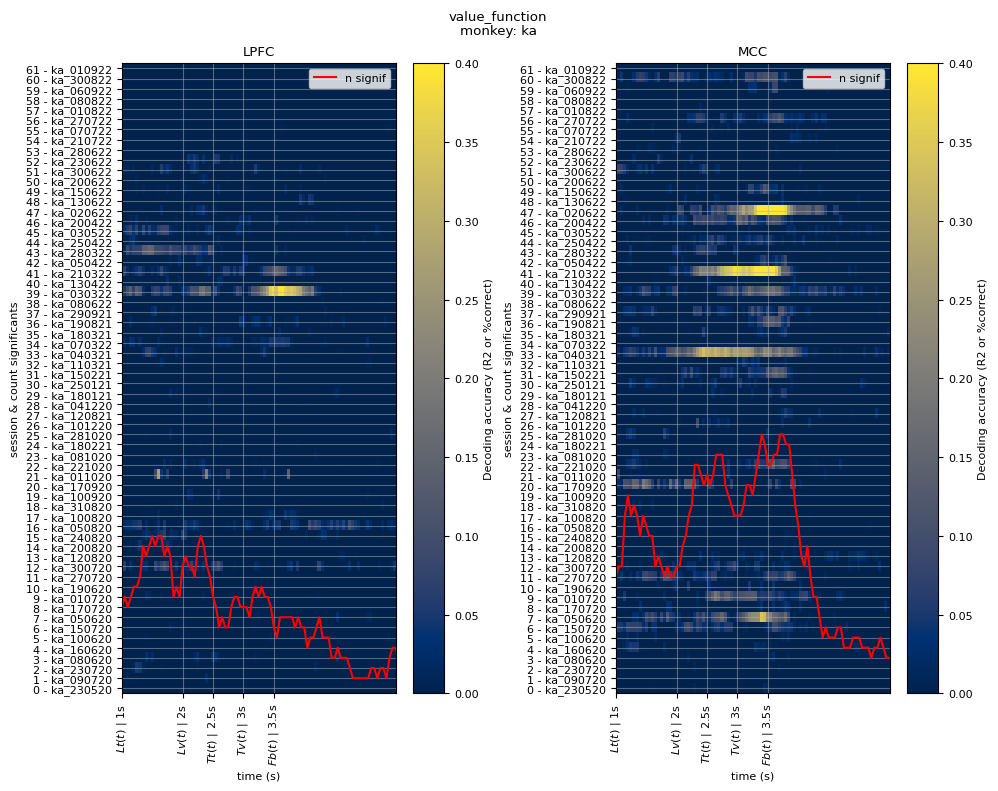

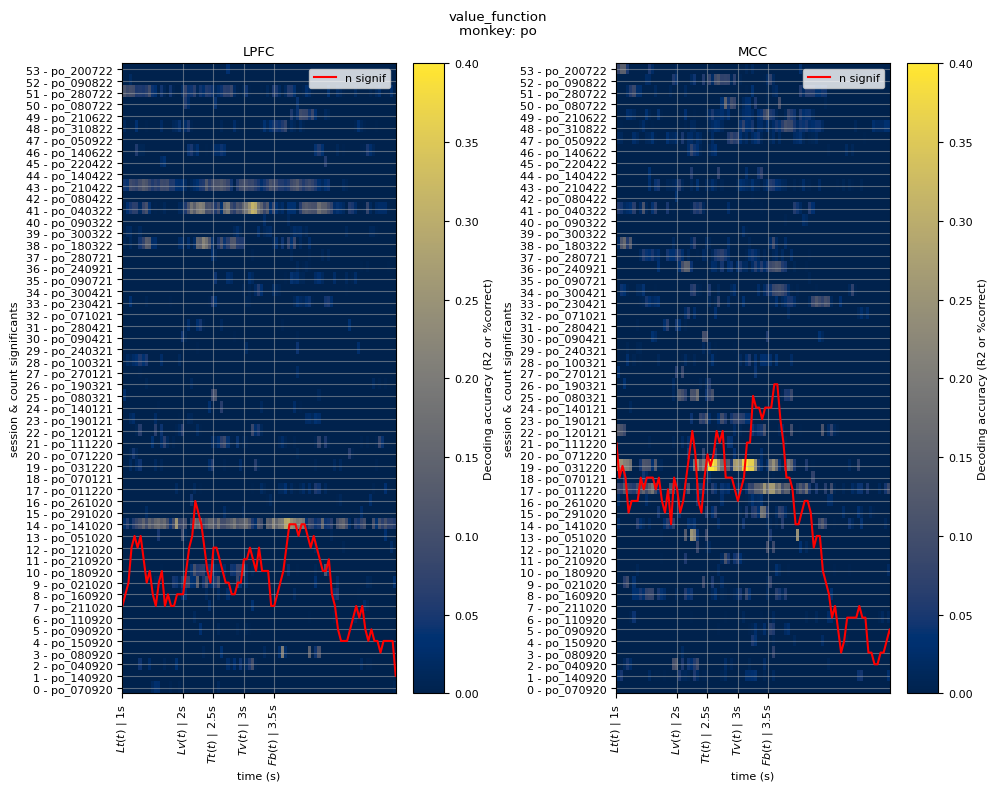

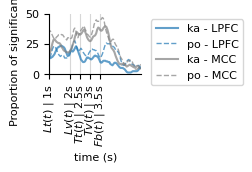

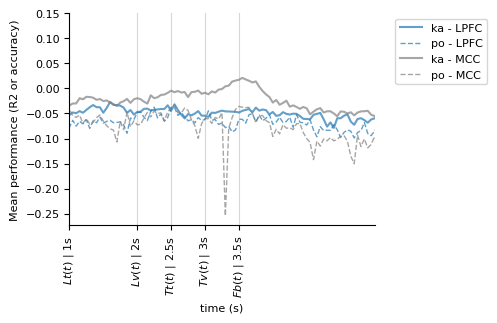

In [4]:
plot_analysis('value_function', 
              plim=.05, 
              vmin=0, vmax=.4, 
              n_extra_trials=(-1, 1), 
              N_consecutives=4,
              x_lim=(1, 5.5),
              prop_lim=[0, 50],
              bar_title='Decoding accuracy (R2)',
              folder='value_new')

## 1.2. New Shift-value

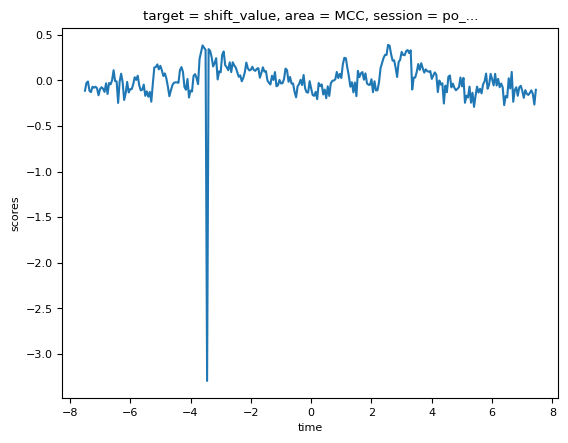

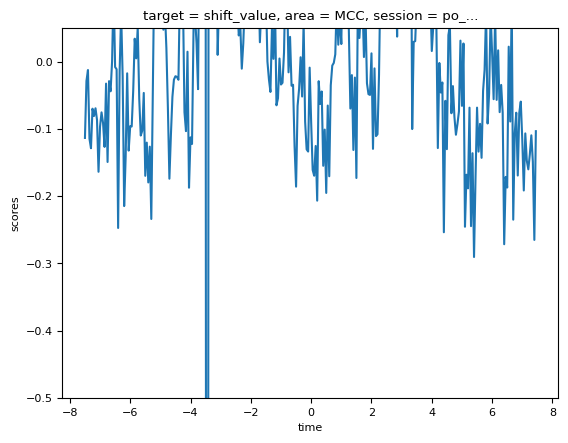

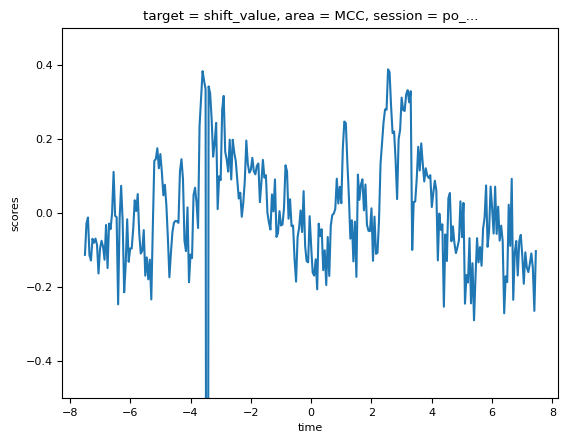

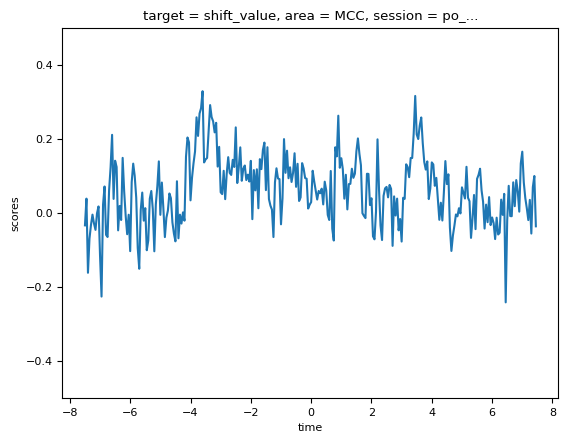

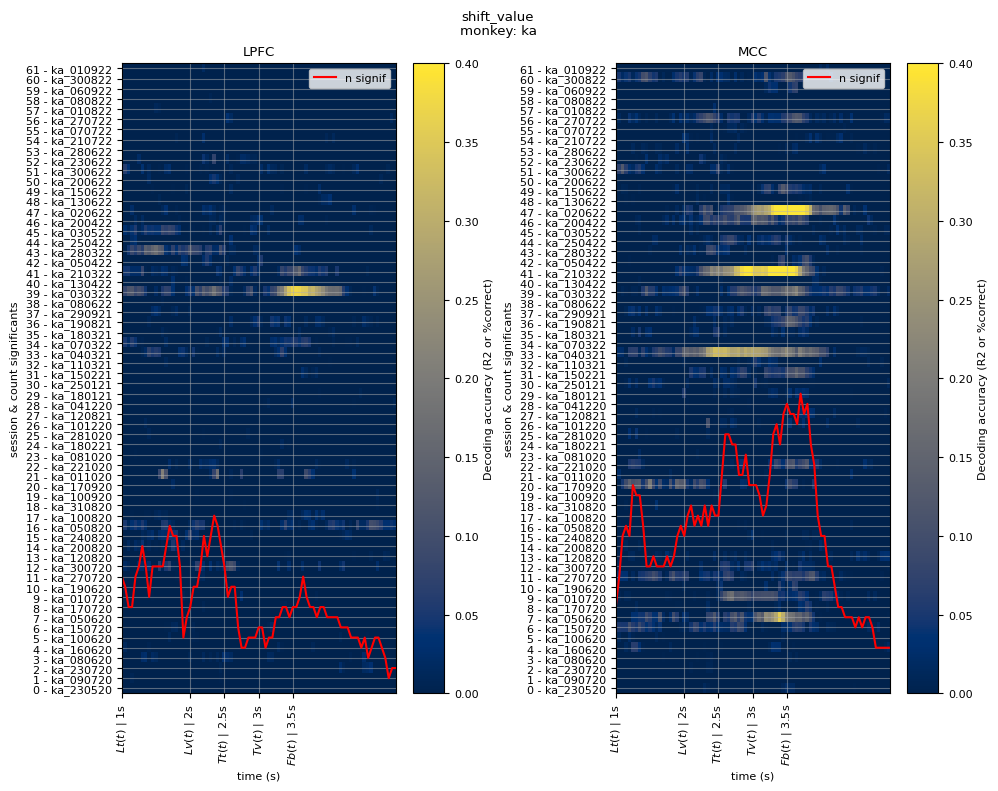

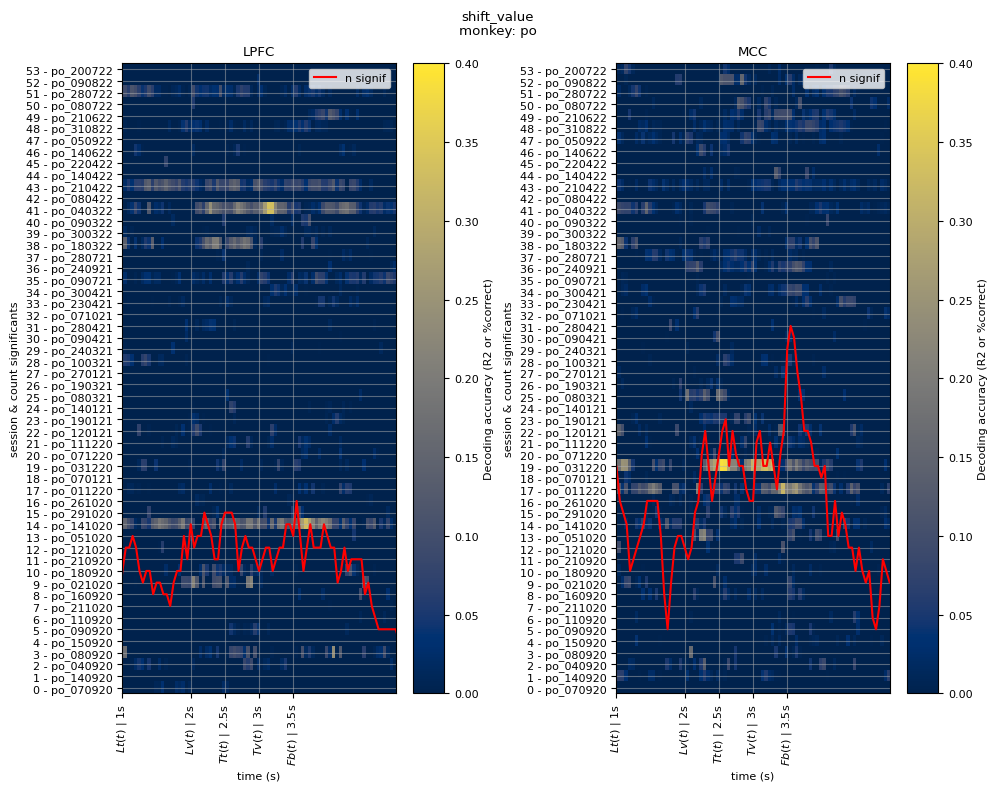

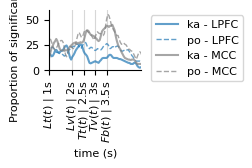

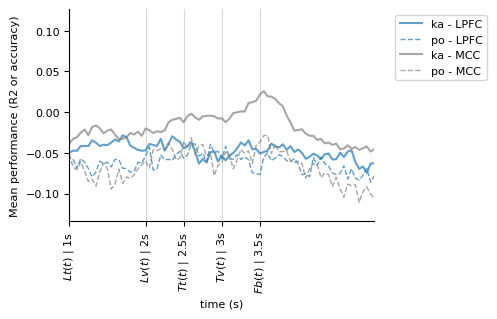

In [14]:
plot_analysis('shift_value', 
              plim=.05, 
              vmin=0, vmax=.4, 
              n_extra_trials=(-1, 1), 
              N_consecutives=4,
              x_lim=(1, 5),
              prop_lim=[0, 60],
              bar_title='Decoding accuracy (R2)',
              folder='value_new')

## 1.3 Across-target CV

In [6]:
res_across = load_decoding_res_new(folder='cross_target')
res_across_baseline = load_decoding_res_new(folder='cross_target_baseline')

res_across

<xarray.Dataset>
Dimensions:    (session: 115, target: 1, time: 300, area: 2)
Coordinates:
  * target     (target) object 'shift_value'
  * area       (area) object 'LPFC' 'MCC'
  * time       (time) float64 -7.5 -7.45 -7.4 -7.35 -7.3 ... 7.3 7.35 7.4 7.45
  * session    (session) object 'ka_230520' 'ka_090720' ... 'po_200722'
    monkey     (session) object 'ka' 'ka' 'ka' 'ka' 'ka' ... 'po' 'po' 'po' 'po'
Data variables:
    scores     (session, target, time, area) float64 nan -0.0101 ... -2.845
    pvals      (session, target, time, area) float64 nan 0.03992 ... 0.976
    perm_mean  (session, target, time, area) float64 nan -0.03238 ... -1.614
    perm_std   (session, target, time, area) float64 nan 0.01383 ... 0.5456
Attributes:
    conditions:      ['shift_value']
    group_target:    target
    K_fold:          3
    step_len:        0.05
    n_perm:          500
    n_extra_trials:  (-1, 0)
    floc:            /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/popula...
    msg:             decoding the shift value across targets.

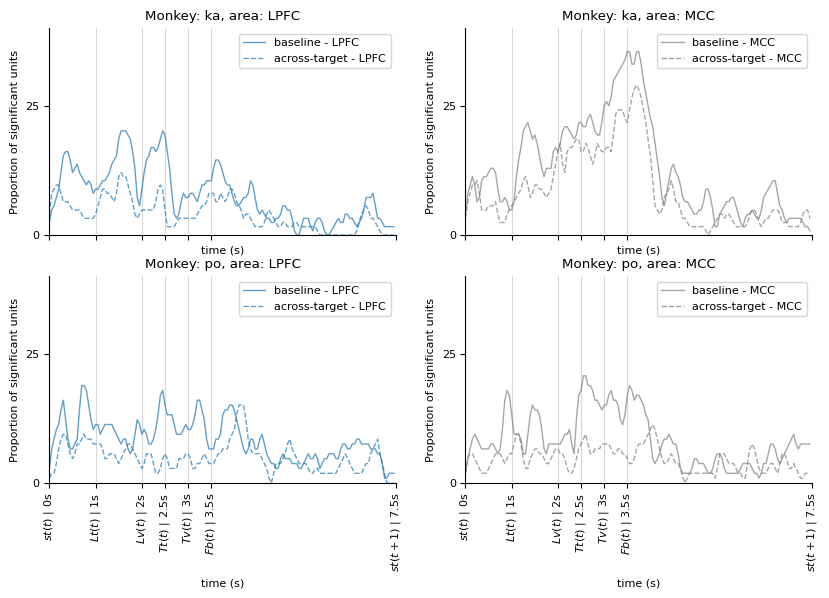

In [7]:
plim=.05
vmin=0
vmax=.4 
n_extra_trials=(-1, 1)
N_consecutives=4
x_lim=(0, 7.5)
prop_lim=[0, 40]
bar_title='Decoding accuracy (R2)'
folder='value_new'

res_target_across = res_across.sel(target='shift_value')
res_target_across_baseline = res_across_baseline.sel(target='shift_value')

if x_lim:
    res_target_across = res_target_across.sel(time=slice(x_lim[0], x_lim[1]))
    res_target_across_baseline = res_target_across_baseline.sel(time=slice(x_lim[0], x_lim[1]))

res_target_ka_across = res_target_across.where(res_target_across.session.str.startswith('ka_'), drop=True)
res_target_po_across = res_target_across.where(res_target_across.session.str.startswith('po_'), drop=True)
res_target_ka_baseline = res_target_across_baseline.where(res_target_across_baseline.session.str.startswith('ka_'), drop=True)
res_target_po_baseline = res_target_across_baseline.where(res_target_across_baseline.session.str.startswith('po_'), drop=True)

mask_target_ka_across = res_target_ka_across.pvals <= plim
mask_target_po_across = res_target_po_across.pvals <= plim
mask_target_ka_baseline = res_target_ka_baseline.pvals <= plim
mask_target_po_baseline = res_target_po_baseline.pvals <= plim

# mask N consecutive non-significant bins
mask_target_ka_across = mask_N_consecutives(mask_target_ka_across, N=N_consecutives)
mask_target_po_across = mask_N_consecutives(mask_target_po_across, N=N_consecutives)
mask_target_ka_baseline = mask_N_consecutives(mask_target_ka_baseline, N=N_consecutives)
mask_target_po_baseline = mask_N_consecutives(mask_target_po_baseline, N=N_consecutives)    

fig, ax = plot_prop_signif_across(mask_target_ka_across, mask_target_ka_baseline, 
                                  mask_target_po_across, mask_target_po_baseline, 
                                  n_extra_trials=n_extra_trials, x_lim=x_lim, prop_lim=prop_lim)


## 1.4 Shift value multiple alphas

In [8]:
res_alphas_original = load_decoding_res_new(folder='multiple_alphas')
res_alphas_original

<xarray.Dataset>
Dimensions:    (session: 116, target: 19, time: 150, area: 2)
Coordinates:
  * target     (target) object 'shift_value_0.05' ... 'shift_value_0.95'
  * area       (area) object 'LPFC' 'MCC'
  * time       (time) float64 0.0 0.05 0.1 0.15 0.2 ... 7.25 7.3 7.35 7.4 7.45
  * session    (session) object 'ka_230520' 'ka_090720' ... 'po_200722'
    monkey     (session) object 'ka' 'ka' 'ka' 'ka' 'ka' ... 'po' 'po' 'po' 'po'
Data variables:
    scores     (session, target, time, area) float64 nan -0.01048 ... -0.1354
    pvals      (session, target, time, area) float64 nan 0.1776 ... 0.3752
    perm_mean  (session, target, time, area) float64 nan -0.02188 ... -0.1486
    perm_std   (session, target, time, area) float64 nan 0.01351 ... 0.04146
Attributes:
    conditions:      ['shift_value_0.05', 'shift_value_0.10', 'shift_value_0....
    group_target:    None
    K_fold:          5
    step_len:        0.05
    n_perm:          500
    n_extra_trials:  (0, 0)
    floc:            /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/popula...
    msg:             Lets see if the alpha of the behavioral model matches wi...

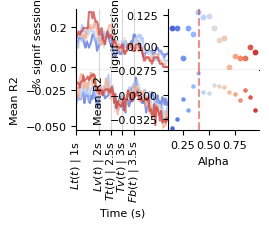

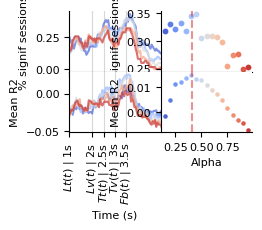

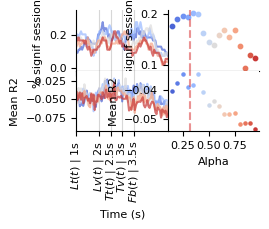

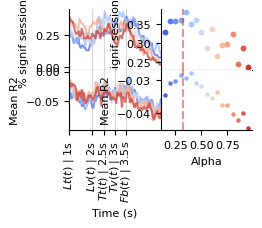

In [9]:
plim=.05
N_consecutives=5
cut_percentile=.10
x_lim=(1, 5)

monkeys = np.unique(res_alphas_original.monkey.values)
areas = np.unique(res_alphas_original.area.values)
targets = res_alphas_original.target.values
alphas = np.linspace(.1, 1, 19)

# color gradient red to green
colors = plt.cm.coolwarm(np.linspace(0, 1, len(targets)))
alpha_monkey = {'ka': .41, 'po': .32}

# plot size in cm
w = 6
h = 4 

for m, monkey_temp in enumerate(monkeys):
    for a, area_temp in enumerate(areas):
            
        fig, axs = plt.subplots(2, 2, figsize=(w/2.54, h/2.54), sharex='col')
        # set padding to 0
        plt.subplots_adjust(wspace=0, hspace=0)
        title = f'Monkey: {monkey_temp}, area: {area_temp}'
        #fig.suptitle(title)
        
        for i, target_temp in enumerate(targets):
            if i == 0 or i == len(targets)-1:
                continue
            
            res_alphas_temp = res_alphas_original.sel(target=target_temp, session=res_alphas_original.monkey == monkey_temp)

            # mask N consecutive non-significant bins
            pvals_temp = res_alphas_temp.pvals <= plim
            pvals_temp = mask_N_consecutives(pvals_temp, N=N_consecutives)
            scores_temp = res_alphas_temp.scores
            scores_temp = scores_temp.where(scores_temp > scores_temp.quantile(cut_percentile), np.nan)
            # remove 0
            #scores_temp = scores_temp.where(scores_temp > scores_temp.quantile(cut_percentile), np.nan)  # remove outliers lower than 5th percentile

            pvals_in_time = np.mean(pvals_temp.sel(area=area_temp).data, axis=0)
            scores_in_time = np.nanmean(scores_temp.sel(area=area_temp).data, axis=0)
            t_interest = [3, 3.5]
            pvals_at_time = np.mean(pvals_temp.sel(area=area_temp, time=slice(*t_interest)).data)
            scores_at_time = np.nanmean(scores_temp.sel(area=area_temp, time=slice(*t_interest)).data)

            if (i-1) % 4 == 0:
                # plot num signif sessions over time
                ax = axs[0, 0]
                #data_in_time = np.convolve(data_in_time, np.ones(5)/5, mode='same')
                ax.plot(res_alphas_temp.time, pvals_in_time, color=colors[i], linewidth=1.5, alpha=.7)

                # plot mean r2 over time
                ax = axs[1, 0]
                #data_in_time = np.convolve(data_in_time, np.ones(5)/5, mode='same')
                ax.plot(res_alphas_temp.time, scores_in_time, color=colors[i], linewidth=1.5, alpha=.7)

            # plot num signif sessions at time
            ax = axs[0, 1]
            ax.scatter(alphas[i], pvals_at_time, color=colors[i], marker='o', s=10)

            # plot mean r2 at time
            ax = axs[1, 1]  
            ax.scatter(alphas[i], scores_at_time, color=colors[i], marker='o', s=5)


        # set plot properties
        for i in range(2):
            plot_keypoints(axs[i, 0], n_extra_trials=(0, 0), fontsize=8, rotation=90)
            axs[i, 0].grid(axis='x', alpha=.5)
            axs[i, 0].set_xlim(x_lim)
            # reset ylim
            ylim = axs[i, 0].get_ylim()
            axs[i, 0].set_ylim(ylim)
            axs[i, 1].axvline(alpha_monkey[monkey_temp], color='tab:red', linestyle='--', alpha=.5, label='best fit monkey')
            #axs[i, 1].legend()
            axs[i, 1].set_xlabel('Alpha')
            axs[i, 0].set_xlabel('Time (s)')
            
            for j in range(2):
                if i == 0:
                    axs[i, j].set_ylabel('% signif sessions')
                else:
                    axs[i, j].set_ylabel('Mean R2')
    
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)

        #plt.tight_layout()

        floc = os.path.join(PATH, 'notebooks', 'decoders', 'population_decoding', 'figs', f'multiple_alphas_{monkey_temp}_{area_temp}.svg')
        fig.savefig(floc, bbox_inches='tight', dpi=300, transparent=True)

## * Q-values

In [10]:
'''plot_analysis('Q_selected', plim=.01, 
              vmin=.0, vmax=.4, 
              n_extra_trials=(-1, 1), 
              x_lim=(1.5, 5.5),
                prop_lim=(0, 50),
              bar_title='Decoding accuracy (R2)',
              folder_ka='basics',
              folder_po='Q_selected_po')'''

"plot_analysis('Q_selected', plim=.01, \n              vmin=.0, vmax=.4, \n              n_extra_trials=(-1, 1), \n              x_lim=(1.5, 5.5),\n                prop_lim=(0, 50),\n              bar_title='Decoding accuracy (R2)',\n              folder_ka='basics',\n              folder_po='Q_selected_po')"

---
# 3. Decoding feedback

In [11]:
folder='fb_target'

res = load_decoding_res_new(folder=folder)
res

<xarray.Dataset>
Dimensions:    (session: 115, target: 2, time: 300, area: 2)
Coordinates:
  * target     (target) object 'feedback' 'target'
  * area       (area) object 'LPFC' 'MCC'
  * time       (time) float64 0.0 0.05 0.1 0.15 0.2 ... 14.8 14.85 14.9 14.95
  * session    (session) object 'ka_230520' 'ka_090720' ... 'po_200722'
    monkey     (session) object 'ka' 'ka' 'ka' 'ka' 'ka' ... 'po' 'po' 'po' 'po'
Data variables:
    scores     (session, target, time, area) float64 nan 0.5479 ... 0.5497
    pvals      (session, target, time, area) float64 nan 0.0479 ... 0.001996
    perm_mean  (session, target, time, area) float64 nan 0.5006 ... 0.3291
    perm_std   (session, target, time, area) float64 nan 0.03345 ... 0.05939
    cv_mean    (session, target, time, area) float64 nan 0.5299 ... 0.4404 0.483
    cv_std     (session, target, time, area) float64 nan 0.02978 ... 0.09615
Attributes:
    conditions:      ['feedback', 'target']
    group_target:    None
    K_fold:          5
    step_len:        0.05
    n_perm:          500
    n_extra_trials:  (0, 1)
    floc:            /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/popula...
    msg:             decoding the new fixed value signal, and comparing it to...

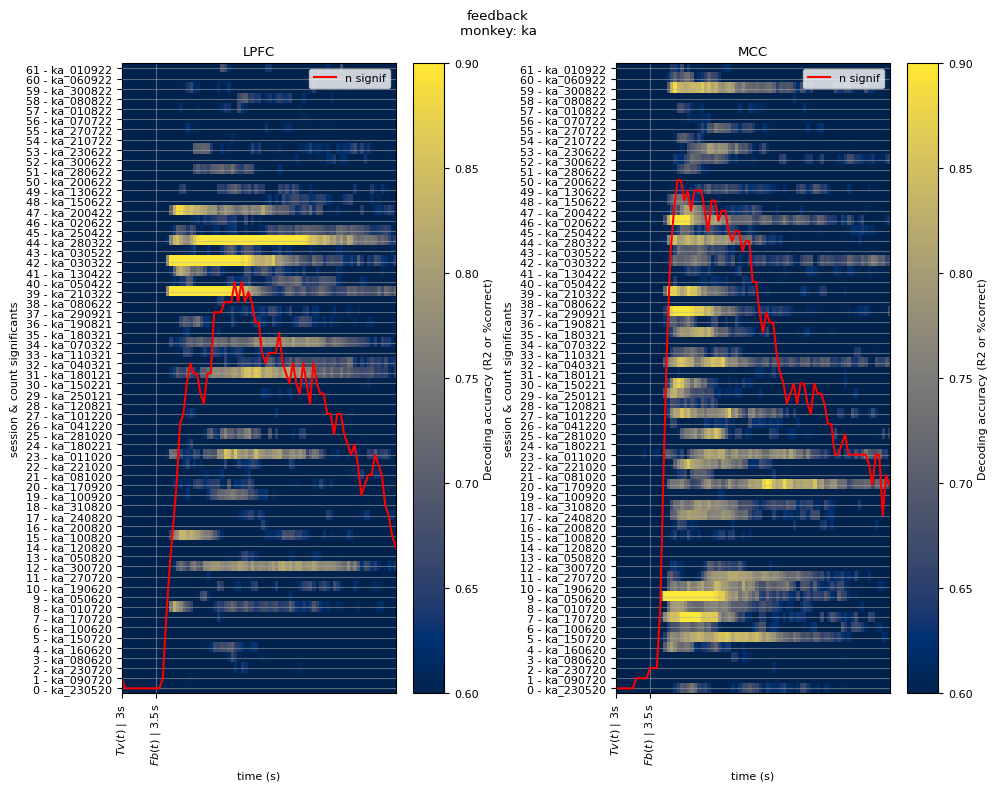

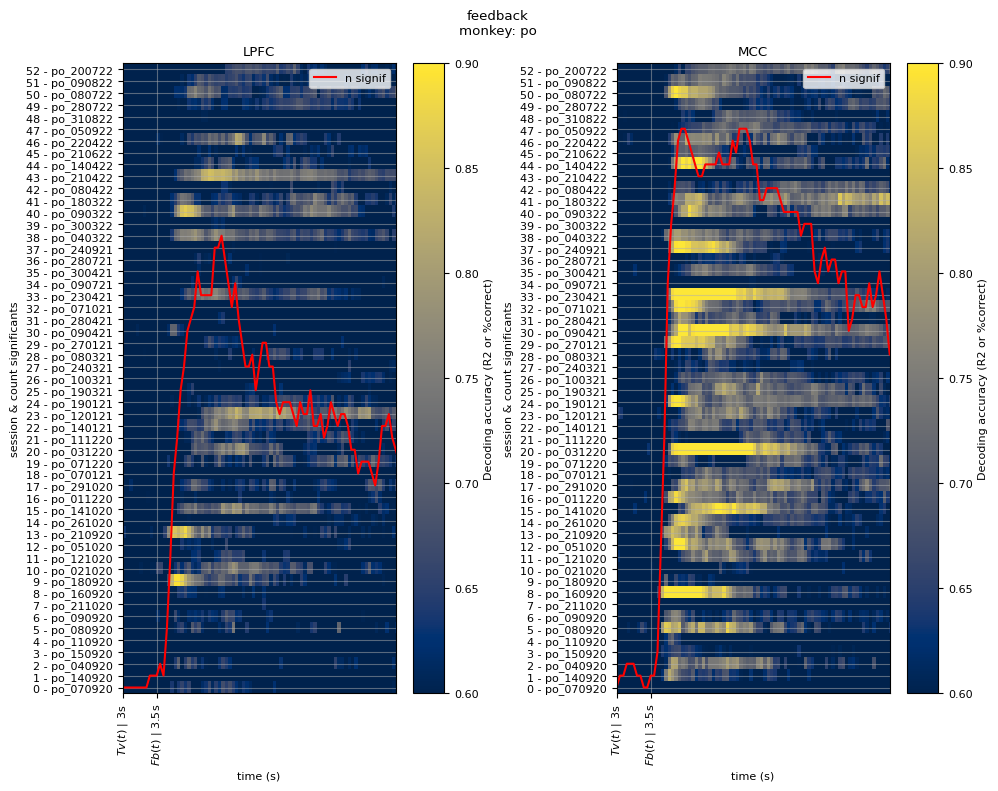

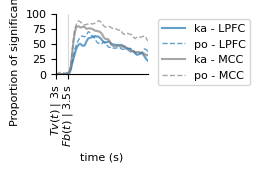

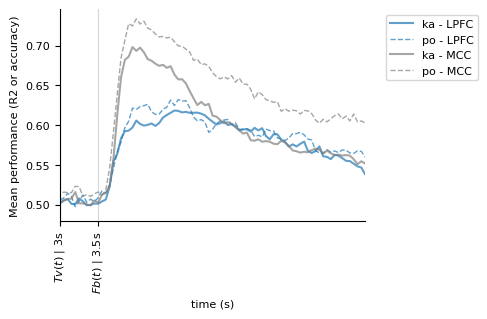

In [12]:
plot_analysis('feedback', 
              plim=.05, 
              vmin=0.6, vmax=.9, 
              n_extra_trials=(-1, 1), 
              N_consecutives=4,
              x_lim=(3, 7),
              prop_lim=[0, 100],
              bar_title='Decoding accuracy (R2)',
              folder='fb_target')

---
# 4. Decoding target

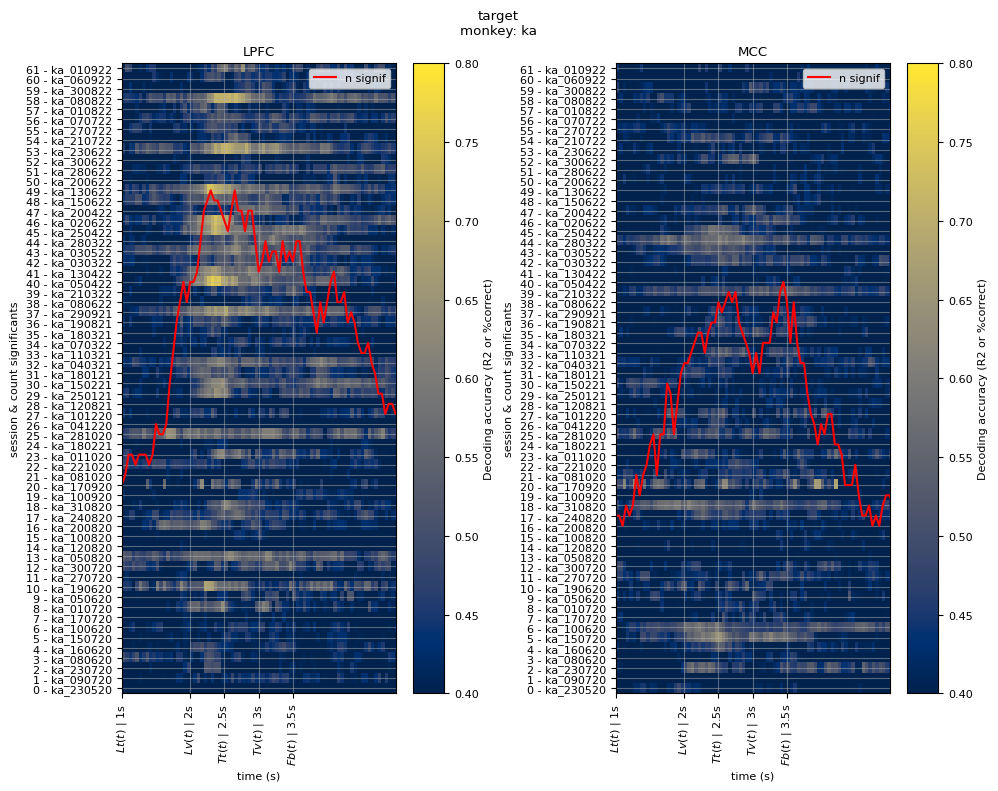

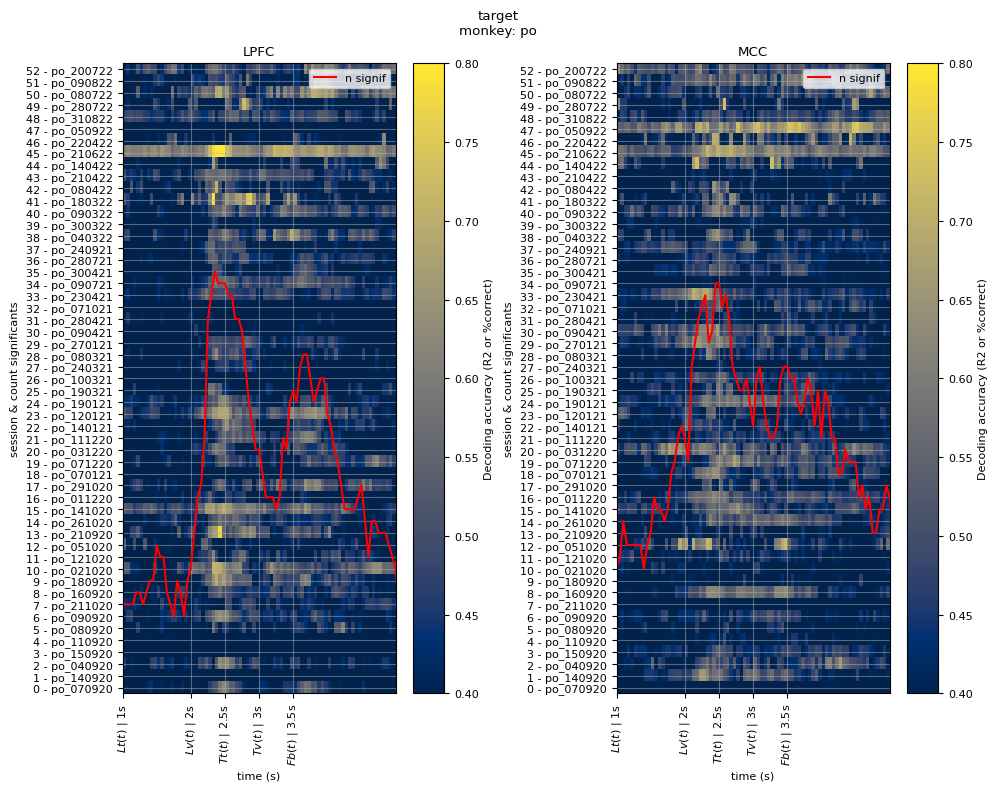

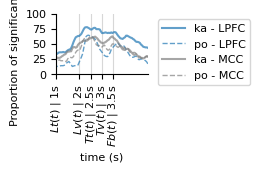

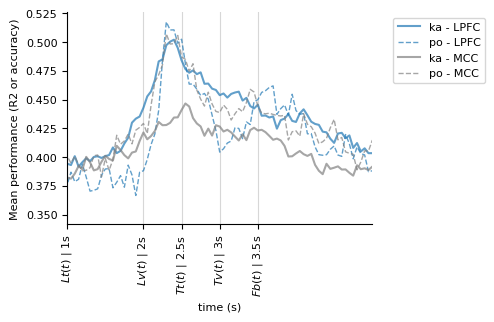

In [13]:
plot_analysis('target', 
              plim=.05, 
              vmin=0.4, vmax=.8, 
              n_extra_trials=(-1, 1), 
              N_consecutives=4,
              x_lim=(1, 5),
              prop_lim=[0, 100],
              bar_title='Decoding accuracy (R2)',
              folder='fb_target')